# Treść zadania

4. „Dobrze byłoby wiedzieć czy dana sesja użytkownika zakończy się zakupem. Dzięki temu nasi konsultanci będą mogli baczniej przyglądać się tym sesjom i szybciej rozwiązywać potencjalne problemy.”

Dane IUM21L_Zad_04_04_v2

Skład zespołu:
* Rafał Kulus (300249)
* Damian Kolaska (300229)

# Etap 1


## Problem biznesowy, zadania modelowania, założenia i kryteria sukcesu

**Problem biznesowy**

Dobrze byłoby wiedzieć czy dana sesja użytkownika zakończy się zakupem. Dzięki temu nasi konsultanci będą mogli baczniej przyglądać się tym sesjom i szybciej rozwiązywać potencjalne problemy.

**Zadanie biznesowe**

Oznaczanie sesji, które są warte uwagi w panelu konsultanta (nie zakończą się zakupem).

**Biznesowe kryterium sukcesu**

Zwiększenie szybkości rozwiązywania problemów przez konsultantów oraz większe zadowolenie klientów mierzone ocenami zakupów.

Zakładamy, że zgłoszenie zajmuje średnio 30min na rozwiązanie. Zatem kryterium sukcesu w tym przypadku to obniżenie tego czasu do 20min. Oczekujemy także poprawienia się średniej oceny klientów o 0.25 (w skali 0-5).

**Zadanie modelowania**

Przygotowanie modelu klasyfikacji na podstawie danych sesji (przewidywanie, czy dana sesja zakończy się zakupem).

**Analityczne kryterium sukcesu**

Co najmniej 50% dokładność w klasyfikowaniu sesji, jeśli sesja składa się z co najmniej 4 zdarzeń.

**Dane do modelowania**

* informacje o sesjach użytkowników
* baza danych klientów
* katalog produktów
* informacje o dostawach zamówień


## Wczytanie danych do pd.DataFrame

In [114]:
pip install jsonlines pandas numpy

In [115]:
import jsonlines
import pandas as pd
import numpy as np

def read_jsonl(path):
    data = []

    with jsonlines.open(path) as reader:
        for obj in reader:
            data.append(obj)

    return pd.DataFrame(data).convert_dtypes()


In [116]:
users = read_jsonl('./users.jsonl')
sessions = read_jsonl('./sessions.jsonl')
deliveries = read_jsonl('./deliveries.jsonl')
products = read_jsonl('./products.jsonl')

## Funkcje pomocnicze

In [117]:
def group_and_count(df, cols):
    return df.groupby(cols).size().reset_index(name='count')

def find_duplicates(df, cols):
    res = group_and_count(df, cols)
    return res.loc[res['count'] > 1]

def get_pmf_data(col):
    counts = col.value_counts()
    sum = 0
    for x in counts:
        sum += x
    return counts.map(lambda x: x / sum)

def get_null_count(df, col):
    return df[df[col].isnull()].shape[0]

def get_total_null_count(df):
    return df[df.isnull().any(axis=1)].shape[0]


## Analiza danych, anomalie i ich poprawa

### Użytkownicy

In [118]:
users

,user_id,name,city,street
0,102,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53
1,103,Mateusz Kobel,Police,al. Wrocławska 10
2,104,Radosław Ratka,Mielec,pl. Nowa 89/04
3,105,Anastazja Oszust,Szczecin,ul. Częstochowska 80
4,106,Sylwia Nurek,Szczecin,al. Wiosenna 72
...,...,...,...,...
195,297,Andrzej Kreczmer,Szczecin,ul. Zdrojowa 43/11
196,298,Natan Świadek,Mielec,pl. Staffa 801
197,299,Jeremi Kajstura,Konin,pl. Wiklinowa 022
198,300,Gustaw Cofała,Gdynia,ulica Krakowska 847


Ze względu na małą wielkość tabeli pozwoliliśmy sobie na jej wizualną analizę. Doszliśmy do wniosku, że nie ma w niej brakujących ani odstających wartości.

Na pierwszy rzut oka wygląda, że kolumny `name` i `street` posiadają unikalne wartości dyskretne nominalne.

In [119]:
find_duplicates(users, ['name'])

,name,count


In [120]:
find_duplicates(users, ['street'])

,street,count


Powyższą hipotezę potwierdziły wywołania funkcji `find_duplicates`. Mając na uwadze typ danych, a także ich unikalność, stwierdziliśmy, że kolumny `name` i `street` nie wnoszą same z siebie żadnej informacji. Owszem, te dane będą mogły zostać w jakiś sposób wykorzystane, jak już będziemy mieli gotowy model, ale na etapie samego modelowania są naszym zdaniem bezużyteczne. Niemniej jednak da się z tych kolumn wyciągnąć wartościowe dane.

Na podstawie danych z kolumny `street` moglibyśmy w teorii wyznaczyć przybliżoną lokalizację w postaci długości i szerokości geograficznej, jednak taki proces byłby zbyt kosztowny i relatywnie mało wniósłby do naszego zbioru danych ze względu na fakt posiadania kolumny `city`.

Z kolumny `name` możemy z dużą dokładnością odgadnąć płeć użytkownika kierując się heurystyką, że imiona kobiet kończą się literą *a* (w przeciwieństwie do imion mężczyzn). Zadanie wydaje się dosyć proste, a uzyskana informacja może się okazać dla nas bardzo cenna na późniejszym etapie.

In [121]:
genders = []
for n in users.name:
    first_name = n.split()[0]
    genders.append('F' if first_name[-1] == 'a' else 'M')

users = users.assign(gender=genders)

users

,user_id,name,city,street,gender
0,102,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,F
1,103,Mateusz Kobel,Police,al. Wrocławska 10,M
2,104,Radosław Ratka,Mielec,pl. Nowa 89/04,M
3,105,Anastazja Oszust,Szczecin,ul. Częstochowska 80,F
4,106,Sylwia Nurek,Szczecin,al. Wiosenna 72,F
...,...,...,...,...,...
195,297,Andrzej Kreczmer,Szczecin,ul. Zdrojowa 43/11,M
196,298,Natan Świadek,Mielec,pl. Staffa 801,M
197,299,Jeremi Kajstura,Konin,pl. Wiklinowa 022,M
198,300,Gustaw Cofała,Gdynia,ulica Krakowska 847,M


Możemy teraz pozbyć się kolumn `name` i `street`, aby nie zaciemniać obrazu. Kolumna `user_id` przyda się przy denormalizacji danych.

In [122]:
users.drop('name', 1, inplace=True)
users.drop('street', 1, inplace=True)

users

,user_id,city,gender
0,102,Police,F
1,103,Police,M
2,104,Mielec,M
3,105,Szczecin,F
4,106,Szczecin,F
...,...,...,...
195,297,Szczecin,M
196,298,Mielec,M
197,299,Konin,M
198,300,Gdynia,M


Na koniec upewnijmy się, że `user_id` nie zawiera duplikatów, a także wygenerujmy wykresy funkcji masy prawdopodobieństwa dla pozostałych dwóch kolumn.

In [123]:
find_duplicates(users, ['user_id'])

,user_id,count


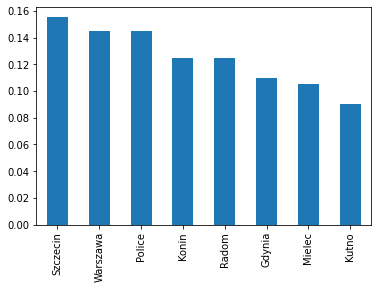

In [124]:
get_pmf_data(users.city).plot(kind='bar')

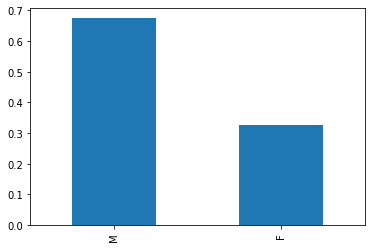

In [125]:
get_pmf_data(users.gender).plot(kind='bar')

### Produkty


In [126]:
products

,product_id,product_name,category_path,price
0,1001,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97
1,1002,Kyocera FS-1135MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,2048.50
2,1003,Kyocera FS-3640MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,7639.00
3,1004,Fallout 3 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
4,1005,Szalone Króliki Na żywo i w kolorze (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
...,...,...,...,...
314,1315,Jabra Talk,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,54.99
315,1316,Plantronics Voyager Legend,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,249.00
316,1317,Plantronics Savi W740,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,1303.96
317,1318,Plantronics Savi W710,Sprzęt RTV;Audio;Słuchawki,553.00


Podobnie jak w przypadku tabeli z użytkownikami, tą tabelę także przeanalizowaliśmy wizualnie i nie zauważyliśmy brakujących danych. W poprzedniej wersji danych znaleźliśmy natomiast 3 problemy:
1. produkt o id == 1076 posiada bardzo długą nazwę, w której nazwa produktu stanowi tylko jej pierwszą część,
2. niektóre produkty posiadają ujemne ceny
3. niektóre produkty posiadają ceny *z kosmosu*

Jednak problemy 2. i 3. w nowych danych nie występują.

#### Ujemne ceny produktów i ceny *z kosmosu*
Pierwotne dane zawierały ujemne ceny oraz ceny, które były 10^6 razy większe od normalnych.
Widzimy, że zostało to poprawione w kolejnej wersji danych.

In [127]:
products[products.price < 0].head(8)

,product_id,product_name,category_path,price


In [128]:
PRICE_THRESHOLD = 100000
products[products.price > PRICE_THRESHOLD].head(8)

,product_id,product_name,category_path,price


#### Nazwy produktów

Sytuacja analogiczna do kolumn `name` i `street` z tabeli z użytkownikami. Po upewnieniu się, że `product_name` nie zawiera duplikatów, możemy pozbyć się tej kolumny, ponieważ nie jesteśmy w stanie wyciągnąć z niej żadnej informacji. Nie przejmujemy się także pojedynczym produktem ze zbyt długą nazwą, ponieważ mimo tego zawiera on na początku właściwą nazwę produktu.

In [129]:
find_duplicates(products, ['product_name'])

,product_name,count


In [130]:
products.drop('product_name', 1, inplace=True)

#### Rozkłady cen i kategorii

Zacznijmy od wygenerowania rozkładu cen.

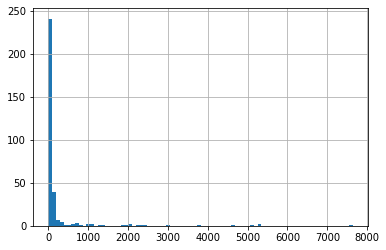

In [131]:
products.price.hist(bins = 80)

Nie wygląda to dobrze, ale trochę przypomina rozkład log-normalny. Spróbujmy zlogarytmować ceny i wygenerować kolejny rozkład.

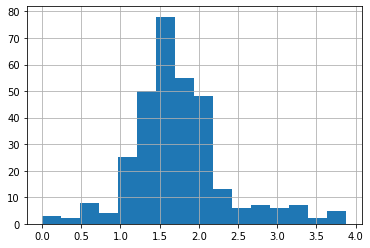

In [132]:
products['price_log'] = np.log10(products.price)
products.price_log.hist(bins = 16)

Ze względu na "grube ogony" rozkład przypomina swoją postacią rozkład Cauchyego.

Zobaczmy, co dostaniemy generując wykresy funkcji masy prawdopodobieństwa dla ścieżek kategorii.

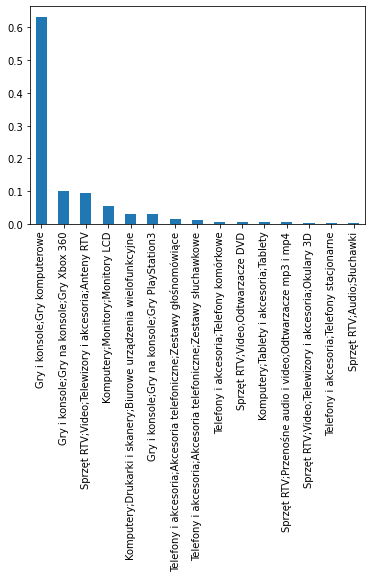

In [133]:
get_pmf_data(products.category_path).plot(kind='bar')

Ponieważ kategorie są wartościami dyskretnymi, nie możemy ich zlogarytmować. Na wykresie powyżej wyraźnie widać, że kategorie znacząco różnią się liczbą produktów, które się w nich znajdują. Całe szczęście możemy spróbować wyciągnąć tylko pierwszą kategorię ze ścieżki. Być może pogrupowanie produktów w ten sposób przyniesie bardziej zrównoważone wyniki.

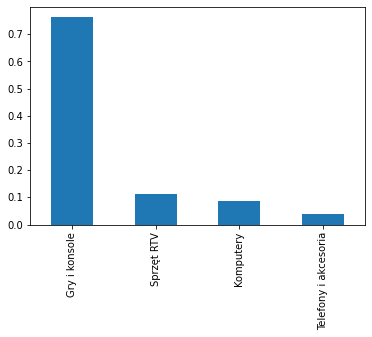

In [134]:
cat_1 = []
for c in products.category_path:
    path = c.split(';')
    cat_1.append(path[0])

products['cat_1'] = cat_1

get_pmf_data(products.cat_1).plot(kind='bar')

Niestety za wiele to nie pomogło. Kategorie w dalszym ciągu są bardzo niezbalansowane. Wpłynie to negatywnie na jakość naszego modelu, chyba że uda nam się uzyskać dostęp do bardziej rozbudowanego zbioru danych.

*Narrator: Nie udało się.*

Spróbujemy po zdenermalizowaniu danych wygenerować wykres ilości wyświetleń produktów w zależności od kategorii, być może on da lepsze wyniki.

### Dostawy

In [135]:
deliveries

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company
0,20001,2021-04-15T07:53:59,2021-04-19T07:54:56,620
1,20002,2021-03-11T10:25:17,2021-03-15T10:27:21,360
2,20003,2021-03-26T19:16:18,2021-03-31T19:18:29,620
3,20004,2021-02-09T23:10:38,2021-02-14T23:14:34,620
4,20005,2021-02-17T22:58:19,2021-02-22T23:01:47,360
...,...,...,...,...
5233,25234,2021-01-07T04:34:02,2021-01-12T04:38:17,360
5234,25235,2021-04-16T10:29:45,2021-04-20T10:33:40,360
5235,25236,2021-03-02T10:35:29,2021-03-04T10:36:18,360
5236,25237,2021-04-02T10:06:02,2021-04-05T10:08:06,360


In [136]:
get_null_count(deliveries, 'purchase_timestamp')

0

In [137]:
get_null_count(deliveries, 'delivery_timestamp')

0

In [138]:
get_null_count(deliveries, 'delivery_company')

0

In [139]:
get_total_null_count(deliveries)

0

W poprzednich danych prawie 10% rekordów posiadało brakujące wartości w kolumnie `delivery_timestamp` lub `delivery_company`. Teraz problem już nie występuje.

In [140]:
deliveries[deliveries.purchase_timestamp >= deliveries.delivery_timestamp].shape[0]

0

Daty są na pierwszy rzut oka również poprawne, tj. czas dostarczenia jest zawsze późniejszy od czasu zakupu.

Zauważyliśmy jednak, że tabela z sesjami również posiada kolumnę `timestamp`. Logiczne by zatem było, aby wartości w kolumnie `timestamp` w tabeli z sesjami pokrywały się z odpowiadającymi wartościami w kolumnie `purchase_timestamp` w tabeli z dostawami, jeśli `event_type == BUY_PRODUCT`. Sprawdźmy to!

In [141]:
del_ses = sessions.merge(deliveries, how='left', on='purchase_id')
del_ses_buy = del_ses[(del_ses.event_type == 'BUY_PRODUCT') & (del_ses.timestamp == del_ses.purchase_timestamp)]
del_ses_buy[['session_id', 'timestamp', 'purchase_timestamp']]

,session_id,timestamp,purchase_timestamp
1,100001,2021-04-15T07:53:59,2021-04-15T07:53:59
10,100002,2021-03-11T10:25:17,2021-03-11T10:25:17
22,100004,2021-03-26T19:16:18,2021-03-26T19:16:18
24,100005,2021-02-09T23:10:38,2021-02-09T23:10:38
27,100006,2021-02-17T22:58:19,2021-02-17T22:58:19
...,...,...,...
35425,109688,2021-01-07T04:34:02,2021-01-07T04:34:02
35430,109689,2021-04-16T10:29:45,2021-04-16T10:29:45
35432,109690,2021-03-02T10:35:29,2021-03-02T10:35:29
35441,109692,2021-04-02T10:06:02,2021-04-02T10:06:02


Liczba otrzymanych rekordów jest równa liczbie rekordów w tabeli z dostawami, co oznacza, że nasza hipoteza została potwierdzona! To oznacza, że kolumna `purchase_timestamp` będzie mogła zostać usunięta po zdenormalizowaniu danych, ponieważ nie wnosi żadnych nowych informacji, które nie są zawarte w kolumnie `timestamp` tabeli z sesjami.

~~Ciągle pozostaje kwestia brakujących danych w kolumnach `delivery_timestamp` lub `delivery_company`.~~ Sama kolumna `delivery_timestamp` nie wnosi informacji, które byłyby przydatne w naszym problemie. Można jednak na jej podstawie i z pomocą kolumny `purchase_timestamp` wyznaczyć, jak długo zajęło wysłanie i dostarczenie paczki. Niestety w dalszym ciągu nie będzie to informacja, która będzie miała znaczenie dla naszego problemu. Podobnie jest z kolumną `delivery_company`. Nasz problem polega na przewidywaniu, czy dana sesja użytkownika zakończy się zakupem. Cała tabela z dostawami zawiera informacje, które są uzupełniane dopiero po dokonaniu zakupu, a zatem nie wpływają na decyzję zakupu, ponieważ nie są znane w momencie jej podejmowania. Czysto teoretycznie można by postawić hipotezę: *jeśli dostarczenie ostatniej paczki klienta zajęło dłużej niż 7 dni, to istnieje duża szansa, że ta osoba nic już u nas nie kupi*. Jednak jeśli dana osoba miałaby u nas już nigdy nic nie kupić, to raczej istnieje też duże prawdopodobieństwo, że ktoś taki przestanie całkowicie korzystać ze strony naszego sklepu, a zatem nie pojawią się sesje, gdzie będziemy mogli na podstawie takiego modelu stwierdzić, że nie dojdzie do zakupu.

Podsumowując, ze względu na ~~relatywnie duży odsetek wybrakowanych danych, a także~~ bardzo małą ilość informacji, które można z nich uzyskać, które byłyby istotne dla naszego problemu, podjęliśmy decyzję o całkowitym odrzuceniu tabeli z dostawami.

### Sesje

In [142]:
sessions

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
0,100001,2021-04-15T07:53:40,102,1283,VIEW_PRODUCT,5,<NA>
1,100001,2021-04-15T07:53:59,102,1283,BUY_PRODUCT,5,20001
2,100002,2021-03-11T10:00:27,102,1076,VIEW_PRODUCT,0,<NA>
3,100002,2021-03-11T10:02:11,102,1080,VIEW_PRODUCT,0,<NA>
4,100002,2021-03-11T10:02:36,102,1079,VIEW_PRODUCT,0,<NA>
...,...,...,...,...,...,...,...
35450,109695,2021-03-31T18:15:24,301,1286,VIEW_PRODUCT,0,<NA>
35451,109695,2021-03-31T18:19:27,301,1288,VIEW_PRODUCT,0,<NA>
35452,109695,2021-03-31T18:21:05,301,1290,VIEW_PRODUCT,0,<NA>
35453,109695,2021-03-31T18:24:39,301,1292,VIEW_PRODUCT,0,<NA>


Mając na uwadze nasze postanowienie o całkowitym odrzuceniu tabeli z dostawami możemy się pozbyć kolumny `purchase_id`.

In [143]:
sessions.drop('purchase_id', 1, inplace=True)

In [144]:
get_null_count(sessions, 'timestamp')

0

In [145]:
get_null_count(sessions, 'user_id')

0

In [146]:
get_null_count(sessions, 'product_id')

0

In [147]:
get_null_count(sessions, 'event_type')

0

In [148]:
get_null_count(sessions, 'offered_discount')

0

In [149]:
get_total_null_count(sessions)

0

~~Jak widać, tylko kolumny `user_id` oraz `product_id` posiadają brakujące dane. Zauważyliśmy jednak, że pojedyncza sesja może posiadać kilka wpisów. Wiemy także, że jedna sesja dotyczy zawsze tylko jednego użytkownika (a przynajmniej się tego domyślamy, ale to także przy okazji sprawdzimy). Możemy w takim razie uzupełnić brakujące dane w kolumnie `user_id` poprzez sprawdzenie, jaka wartość znajduje się w innych wierszach dotyczących tej samej sesji (posiadających tą samą wartość `session_id`).~~

W nowej wersji danych powyższy problem już nie występuje.

In [150]:
# for i, s in sessions[sessions.user_id.isnull()].iterrows():
#     rec_id = -1
#     for j, r in sessions[sessions.session_id == s.session_id].iterrows():
#         if not pd.isnull(r.user_id):
#             if rec_id == -1 or rec_id == r.user_id:
#                 rec_id = r.user_id
#             else: 
#                 raise Exception("Two distinct users in one session")
#     if rec_id != -1:
#         sessions.at[i, 'user_id'] = rec_id
# 
# get_null_count(sessions, 'user_id')

In [151]:
sessions[sessions.user_id.isnull()].session_id.nunique()

0

In [152]:
sessions.session_id.nunique()

9695

~~Niestety w dalszym ciągu nie udało nam się pozbyć brakujących wartości w kolumnie `user_id`. Całe szczęście sesje, które nie posiadają ani jednej wartości we wspomnianej kolumnie stanowią mniej niż 1.1% wszystkich sesji, a zatem nic nie stoi na przeszkodzie, aby całkowicie je usunąć z naszego zbioru.~~

In [153]:
# sessions.drop(sessions[sessions.user_id.isnull()].index, inplace=True)
# sessions[sessions.product_id.isnull()].session_id.nunique()

~~Nie zmienia to jednak faktu, że w dalszym ciągu prawie 16% sesji posiada co najmniej jedną brakującą wartość w kolumnie `product_id`, której nie można w podobny sposób odzyskać. Nie możemy się pozbyć całej kolumny, ponieważ jest kluczowa dla naszego problemu. Jeśli nie otrzymamy lepszych danych, będziemy zmuszeni pozbyć się wszystkich sesji, którym brakuje co najmniej jednej wartości w kolumnie `product_id`. Nie możemy usunąć pojedynczych wpisów z brakującymi wartościami, ponieważ spowoduje to *zmodyfikowanie sesji*, a taka sytuacja prawdopodobnie o wiele bardziej odbije się na jakości naszego modelu niż usunięcie całych sesji.~~

In [154]:
sessions.shape[0] / sessions.session_id.nunique()

3.6570397111913358

Każda sesja posiada średnio ~3.66 zdarzeń.

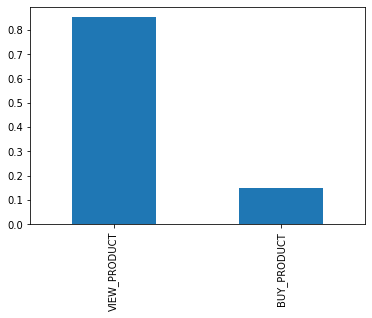

In [155]:
get_pmf_data(sessions.event_type).plot(kind='bar')

In [156]:
success = 0
fail = 0
visited = []
for i, s in sessions.iterrows():
    buy = False
    if s.session_id not in visited:
        visited.append(s.session_id)
        for j, r in sessions[sessions.session_id == s.session_id].iterrows():
            if r.event_type == 'BUY_PRODUCT':
                buy = True
        if buy:
            success += 1
        else:
            fail += 1


Success: 5238
Fail: 4457


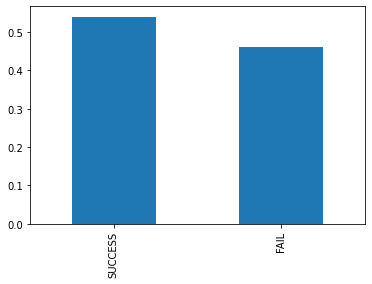

In [157]:
print(f'Success: {success}')
print(f'Fail: {fail}')
all = success + fail
pd.Series({"SUCCESS": success/all, "FAIL": fail/all}).plot(kind='bar')

Z powyższego wykresu wynika, że mniej więcej połowa sesji zakończyła się zakupem. Jest to bardzo dobra wiadomość, ponieważ nie będziemy musieli stosować under/oversamplingu.

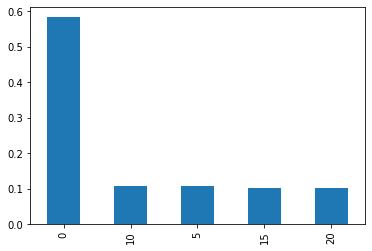

In [158]:
get_pmf_data(sessions.offered_discount).plot(kind='bar')

In [159]:
sessions.timestamp = pd.to_datetime(sessions.timestamp)
sessions['hour'] = sessions.timestamp.dt.hour
sessions['weekday'] = sessions.timestamp.dt.day_name()

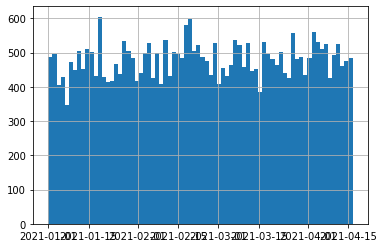

In [160]:
sessions.timestamp.hist(bins=74)

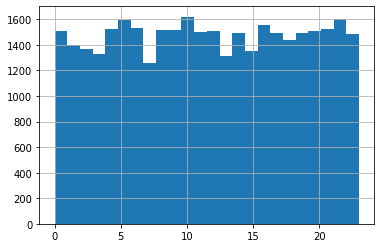

In [161]:
sessions.hour.hist(bins=24)

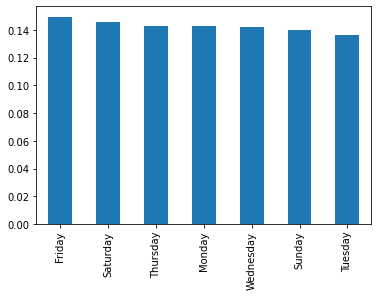

In [162]:
get_pmf_data(sessions.weekday).plot(kind='bar')

## Denormalizacja



In [163]:
data = sessions.merge(users, how='left', on='user_id').merge(products, how='left', on='product_id')

In [164]:
data

,session_id,timestamp,user_id,product_id,event_type,offered_discount,hour,weekday,city,gender,category_path,price,price_log,cat_1
0,100001,2021-04-15 07:53:40,102,1283,VIEW_PRODUCT,5,7,Thursday,Police,F,Sprzęt RTV;Video;Telewizory i akcesoria;Okular...,99.99,1.999957,Sprzęt RTV
1,100001,2021-04-15 07:53:59,102,1283,BUY_PRODUCT,5,7,Thursday,Police,F,Sprzęt RTV;Video;Telewizory i akcesoria;Okular...,99.99,1.999957,Sprzęt RTV
2,100002,2021-03-11 10:00:27,102,1076,VIEW_PRODUCT,0,10,Thursday,Police,F,Komputery;Drukarki i skanery;Biurowe urządzeni...,2399.00,3.380030,Komputery
3,100002,2021-03-11 10:02:11,102,1080,VIEW_PRODUCT,0,10,Thursday,Police,F,Komputery;Drukarki i skanery;Biurowe urządzeni...,5301.90,3.724432,Komputery
4,100002,2021-03-11 10:02:36,102,1079,VIEW_PRODUCT,0,10,Thursday,Police,F,Komputery;Drukarki i skanery;Biurowe urządzeni...,4598.00,3.662569,Komputery
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35450,109695,2021-03-31 18:15:24,301,1286,VIEW_PRODUCT,0,18,Wednesday,Warszawa,F,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...,59.99,1.778079,Sprzęt RTV
35451,109695,2021-03-31 18:19:27,301,1288,VIEW_PRODUCT,0,18,Wednesday,Warszawa,F,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...,119.00,2.075547,Sprzęt RTV
35452,109695,2021-03-31 18:21:05,301,1290,VIEW_PRODUCT,0,18,Wednesday,Warszawa,F,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...,169.00,2.227887,Sprzęt RTV
35453,109695,2021-03-31 18:24:39,301,1292,VIEW_PRODUCT,0,18,Wednesday,Warszawa,F,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...,189.00,2.276462,Sprzęt RTV


## Więcej wykresów po zdenormalizowaniu

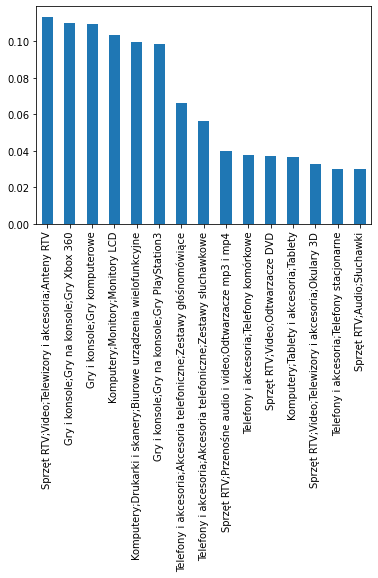

In [165]:
get_pmf_data(data.category_path).plot(kind='bar')

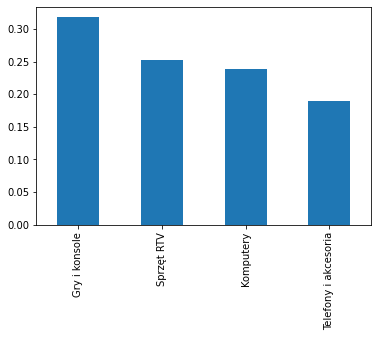

In [166]:
get_pmf_data(data.cat_1).plot(kind='bar')

Jak widać powyżej, rozkład liczby wyświetleń produktów w zależności od kategorii jest o wiele bardziej równomierny w porównaniu do rozkładu liczby produktów oferowanych w sklepie. Jest to bardzo dobra informacja, ponieważ rozkład wyświetleń produktów jest dla nas ważniejszy od rozkładu samej liczby produktów.

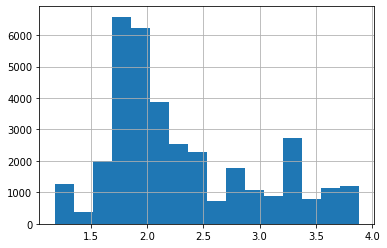

In [167]:
data.price_log.hist(bins=16)

Widać też, że rozkład liczby wyświetleń produktów w zależności od (zlogarytmowanej) ceny nie przypomina już ładnego rozkładu Cauchyego. Ciężko nazwać powyższy rozkład. Wynika z niego na pewno, że produkty kosztujące ponad 1000 zł nie są aż tak rzadko wyświetlane.

In [168]:
gdata = data.groupby(['session_id', 'city', 'gender'], as_index=False).count()

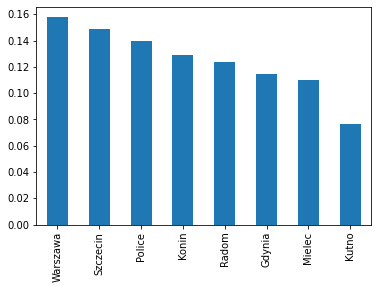

In [169]:
get_pmf_data(gdata.city).plot(kind='bar')

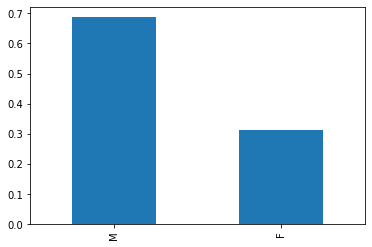

In [170]:
get_pmf_data(gdata.gender).plot(kind='bar')

Powyższe dwa wykresy przedstawiają rozkłady miast i płci klientów zarejestrowanych sesji. Nie wymagają one raczej większego komentarza.